# Cytosol Only Cellpose Segmentation

In [1]:
import os
import numpy as np

from scportrait.pipeline.featurization import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolOnlySegmentationCellpose
from scportrait.pipeline.selection import LMDSelection
import scportrait

In [ ]:
project_location = "project_cytosol_only"
config_path = scportrait.data.get_config_file(config_id = "dataset_1_config")

project = Project(
    os.path.abspath(project_location),
    config_path=config_path,
    overwrite=True,
    debug=True,
    segmentation_f=CytosolOnlySegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    featurization_f=CellFeaturizer,
    selection_f=LMDSelection,
)

Updating project config file.
[10/04/2025 18:43:50] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_sharded/config.yml
[10/04/2025 18:43:50] Compression algorithm for extracted single-cell images: lzf


In [3]:
dataset_1_path = scportrait.data.dataset_1()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_1_path}/Ch1.tif", f"{dataset_1_path}/Ch2.tif", f"{dataset_1_path }/Ch3.tif"]

project.load_input_from_tif_files(images)

[10/04/2025 18:43:50] Output location /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_sharded/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_sharded/sc
         portrait.sdata                                                                                            


[10/04/2025 18:43:50] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_v25y624r for Project
[10/04/2025 18:43:51] Image input_image written to sdata object.
[10/04/2025 18:43:51] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_v25y624r'>


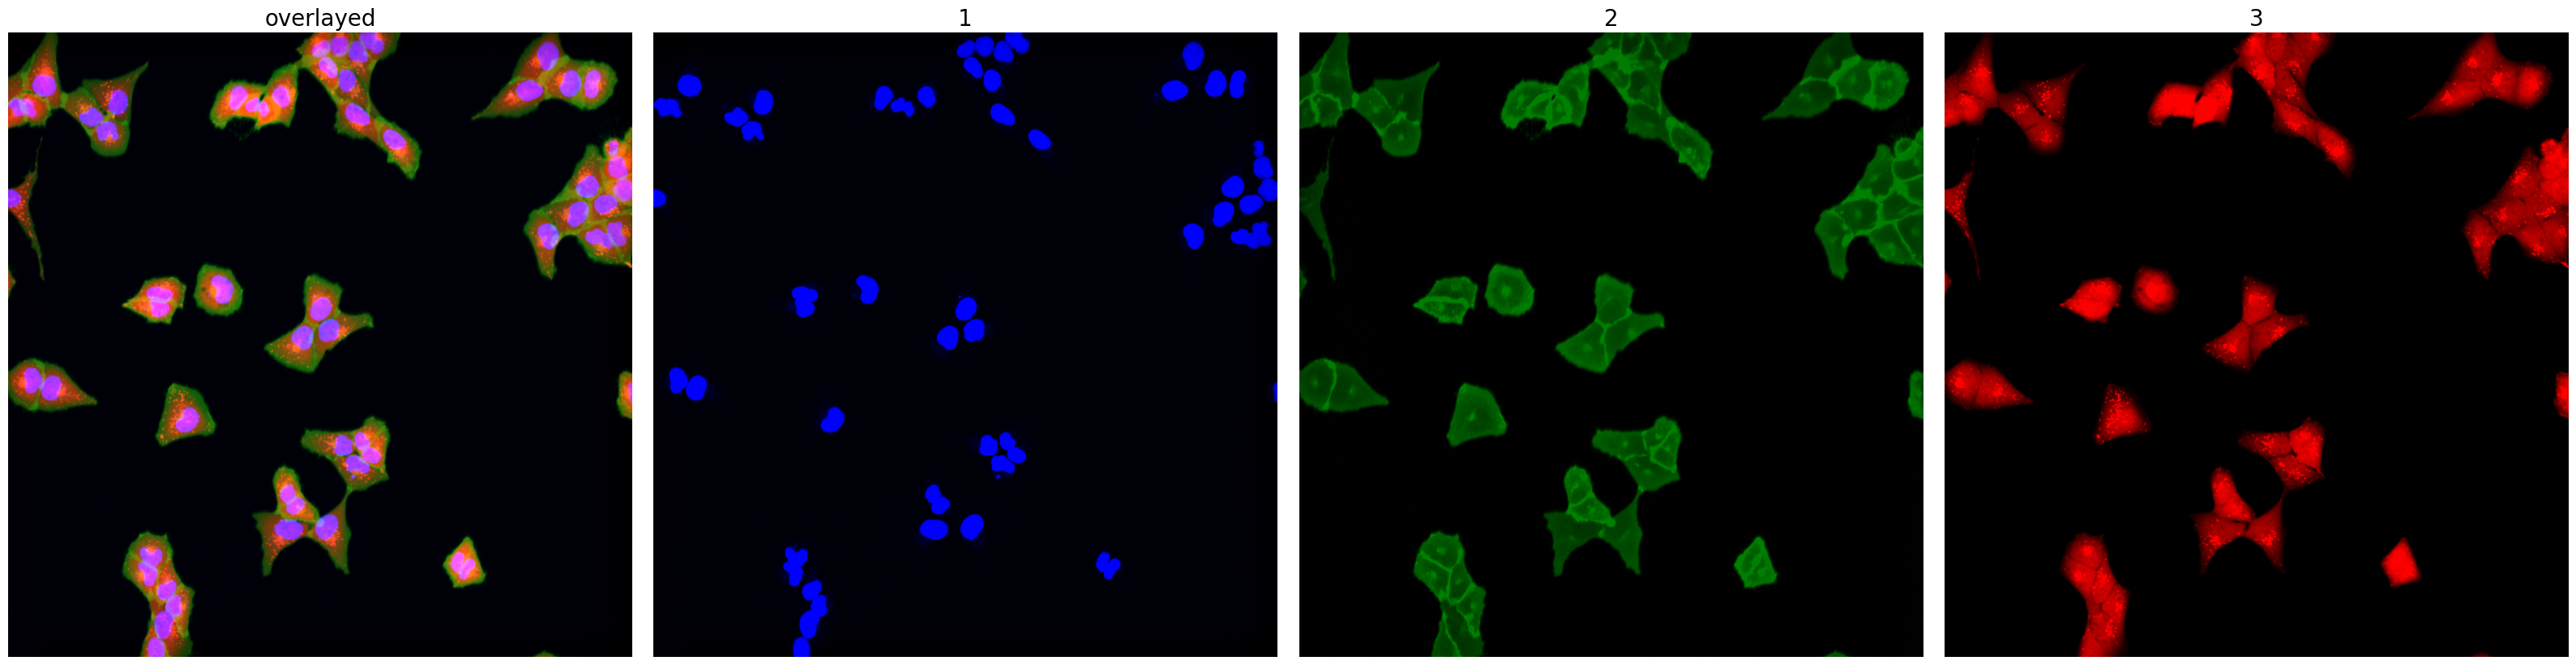

In [4]:
project.plot_input_image()

In [5]:
project.segment()

[10/04/2025 18:43:53] GPU Status for segmentation is True and will segment using the following device mps.
[10/04/2025 18:43:53] Segmentation will be performed wtih all 1 found GPUs.
[10/04/2025 18:43:53] GPU Status for segmentation is True with 1 GPUs found. Segmentation will be performed on the device mps with 1 processes per device in parallel.
[10/04/2025 18:43:53] Segmenting cytosol using the following model: cyto2
[10/04/2025 18:44:13] Segmentation seg_all_cytosol written to sdata object.
[10/04/2025 18:44:15] Points centers_seg_all_cytosol written to sdata object.


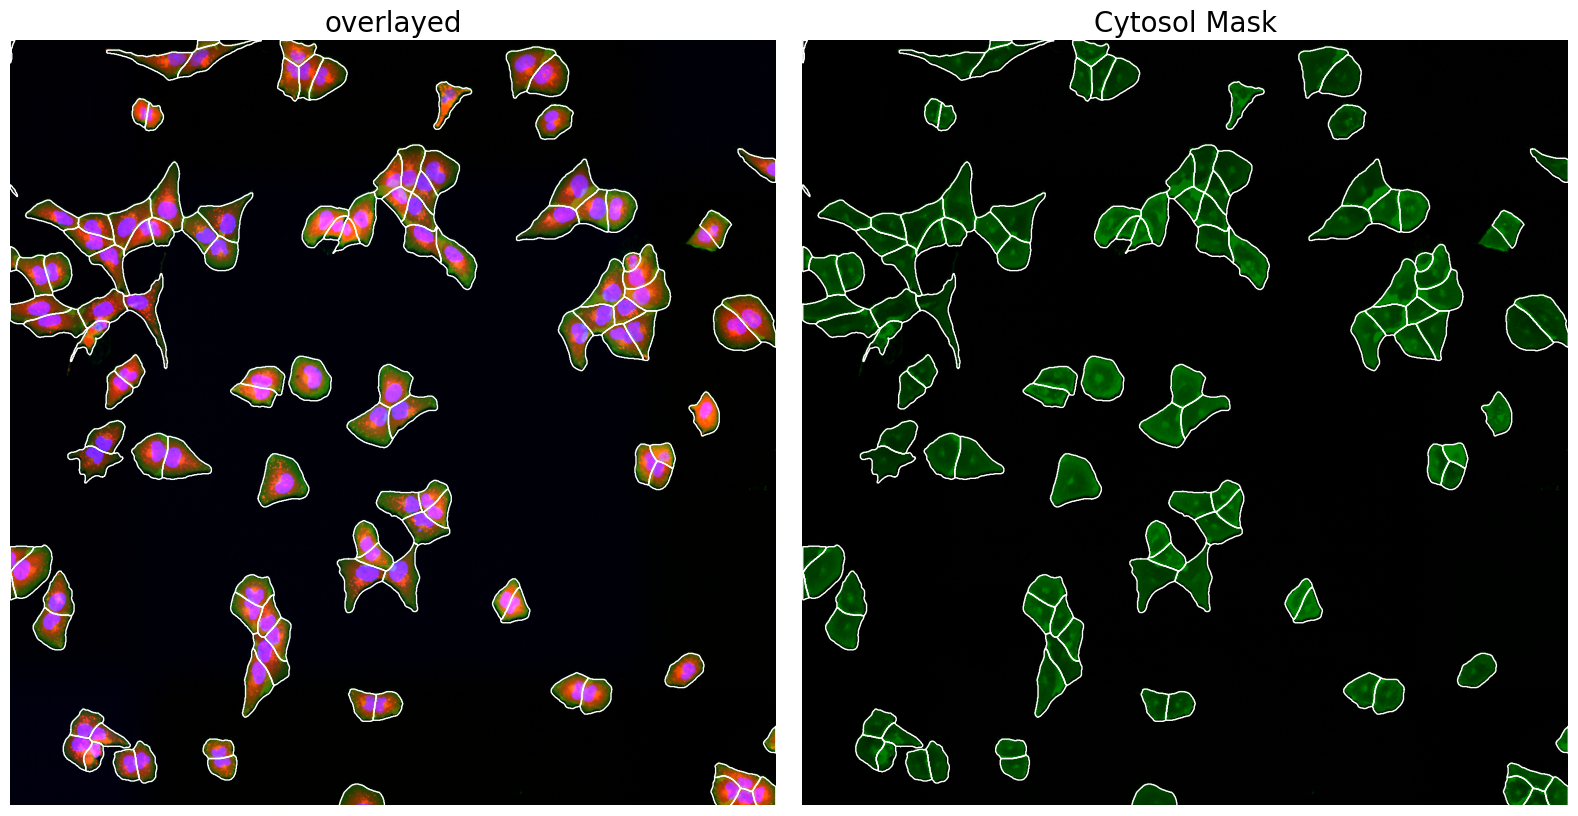

In [6]:
project.plot_segmentation_masks()

In [7]:
project.extract()

[10/04/2025 18:44:16] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_54uafpy5 for HDF5CellExtraction
[10/04/2025 18:44:16] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_sharded/extraction/data
[10/04/2025 18:44:16] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_sharded/extraction/data
[10/04/2025 18:44:16] Found 1 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_cytosol']
[10/04/2025 18:44:16] Using seg_all_cytosol as the main segmentation mask to determine cell centers.
[10/04/2025 18:44:16] A total of 9 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/proj

Extracting cell batches:   0%|          | 0/5 [00:00<?, ?it/s]

[10/04/2025 18:44:17] Finished extraction in 0.49 seconds (911.40 cells / second)
[10/04/2025 18:44:17] Benchmarking times saved to file.
[10/04/2025 18:44:17] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_54uafpy5'>


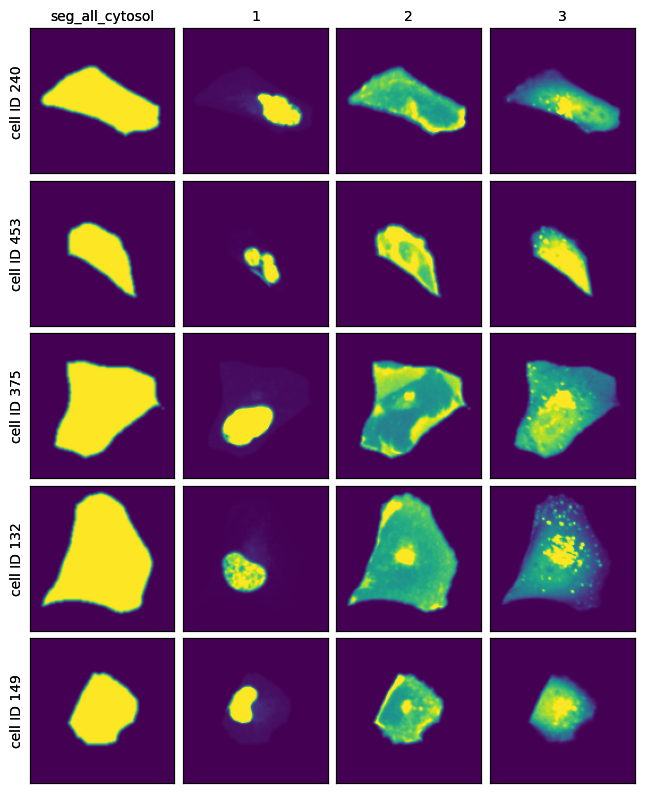

In [8]:
project.plot_single_cell_images()

In [9]:
project.featurize(overwrite=True)

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_sharded/extraction/data/single_cells.h5sc
[10/04/2025 18:44:18] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CellFeaturizer_xvthg89e for CellFeaturizer
[10/04/2025 18:44:18] Started CellFeaturization of all available channels.
[10/04/2025 18:44:18] Overwrite flag is set, deleting existing directory for featurization results.
[10/04/2025 18:44:18] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_sharded/featurization/complete_CellFeaturizer
[10/04/2025 18:44:18] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[10/04/2025 18:44:18] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CellFeaturizer_tjrudd87 for CellFeaturizer
[10/04/2025 18:44

In [12]:
# load classification results
results = project.sdata['CellFeaturizer_cytosol'].to_df().merge(project.sdata['CellFeaturizer_cytosol'].obs, left_index=True, right_index=True).drop(columns = "region")
results

,cytosol_area,1_mean_cytosol,1_median_cytosol,1_quant75_cytosol,1_quant25_cytosol,1_summed_intensity_cytosol,1_summed_intensity_area_normalized_cytosol,2_mean_cytosol,2_median_cytosol,2_quant75_cytosol,2_quant25_cytosol,2_summed_intensity_cytosol,2_summed_intensity_area_normalized_cytosol,3_mean_cytosol,3_median_cytosol,3_quant75_cytosol,3_quant25_cytosol,3_summed_intensity_cytosol,3_summed_intensity_area_normalized_cytosol,scportrait_cell_id
0,6927.0,0.074052,0.0,0.026459,0.0,1213.260132,0.175149,0.240117,0.0,6.782227e-01,0.0,3934.084961,0.567935,0.138888,0.0,1.565247e-01,0.0,2275.539795,0.328503,22
1,3981.0,0.055688,0.0,0.000000,0.0,912.390259,0.229186,0.111980,0.0,0.000000e+00,0.0,1834.676514,0.460858,0.103961,0.0,0.000000e+00,0.0,1703.289062,0.427855,25
2,5229.0,0.076646,0.0,0.019680,0.0,1255.772705,0.240155,0.204406,0.0,1.302185e-01,0.0,3348.983154,0.640463,0.154911,0.0,3.311920e-02,0.0,2538.057617,0.485381,26
3,3442.0,0.046036,0.0,0.000000,0.0,754.248169,0.219131,0.105017,0.0,0.000000e+00,0.0,1720.605835,0.499885,0.093497,0.0,0.000000e+00,0.0,1531.860107,0.445049,27
4,5463.0,0.057873,0.0,0.008547,0.0,948.198181,0.173567,0.182684,0.0,9.886169e-02,0.0,2993.100098,0.547886,0.133167,0.0,1.339340e-02,0.0,2181.808594,0.399379,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,4209.0,0.034690,0.0,0.000000,0.0,568.368042,0.135036,0.142048,0.0,2.533197e-07,0.0,2327.313721,0.552937,0.095533,0.0,5.960464e-08,0.0,1565.213257,0.371873,496
440,3285.0,0.059075,0.0,0.000000,0.0,967.881714,0.294637,0.102969,0.0,0.000000e+00,0.0,1687.039551,0.513558,0.082061,0.0,0.000000e+00,0.0,1344.489014,0.409281,497
441,5578.0,0.038588,0.0,0.001783,0.0,632.225708,0.113343,0.203797,0.0,2.258301e-01,0.0,3339.014648,0.598604,0.124447,0.0,1.148605e-02,0.0,2038.937622,0.365532,498
442,5595.0,0.052219,0.0,0.002640,0.0,855.557251,0.152915,0.178292,0.0,3.445435e-01,0.0,2921.138184,0.522098,0.134353,0.0,4.961395e-02,0.0,2201.232910,0.393429,499


In [13]:
#test selection workflow
selected_cells_large = results[results.cytosol_area > 4500]["scportrait_cell_id"].tolist()
selected_cells_small = results[results.cytosol_area < 3000]["scportrait_cell_id"].tolist()

cells_to_select = [
    {"name": "large_cells", "classes": selected_cells_large, "well": "A1"},
    {"name": "small_cells", "classes": selected_cells_small, "well": "B1"},
]

marker_0 = (0, 0)
marker_1 = (2000, 0)
marker_2 = (0, 2000)

calibration_marker = np.array([marker_0, marker_1, marker_2])


[10/04/2025 18:54:05] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_o6leww5l for LMDSelection
[10/04/2025 18:54:05] Selection process started.


Processing cell batches:   0%|          | 0/3 [00:00<?, ?it/s]

[10/04/2025 18:54:24] Temporary directory not found, skipping cleanup
[10/04/2025 18:54:25] Temporary directory not found, skipping cleanup
[10/04/2025 18:54:25] Temporary directory not found, skipping cleanup
[10/04/2025 18:54:26] Coordinate lookup index calculation took 21.56136850002804 seconds.
No configuration for shape_erosion found, parameter will be set to 0
No configuration for binary_smoothing found, parameter will be set to 3
No configuration for convolution_smoothing found, parameter will be set to 15
No configuration for rdp_epsilon found, parameter will be set to 0.1
No configuration for xml_decimal_transform found, parameter will be set to 100
No configuration for distance_heuristic found, parameter will be set to 300
No configuration for join_intersecting found, parameter will be set to True
Path optimizer used for XML generation: hilbert
cell set 0 passed sanity check
cell set 1 passed sanity check
Loading coordinates from external source
Processing cell sets in parall

collecting cell sets:   0%|          | 0/2 [00:00<?, ?it/s]

Convert label format into coordinate format
Conversion finished, performing sanity check.
Intersecting Shapes will be merged into a single shape.
Convert label format into coordinate format
Conversion finished, performing sanity check.
Intersecting Shapes will be merged into a single shape.


dilating shapes: 100%|██████████| 208/208 [00:07<00:00, 28.97it/s]


0 shapes that were intersecting were found and merged.


calculating polygons:   0%|          | 0/34 [00:00<?, ?it/s]

0 shapes that were intersecting were found and merged.


calculating polygons: 100%|██████████| 34/34 [00:05<00:00,  6.65it/s]


Current path length: 34,667.38 units
Optimized path length: 15,473.04 units
Optimization factor: 2.2x


creating shapes:   1%|          | 1/81 [00:03<04:41,  3.52s/it]

Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.


calculating polygons: 100%|██████████| 81/81 [00:08<00:00,  9.50it/s]


Current path length: 82,683.68 units
Optimized path length: 27,214.13 units
Optimization factor: 3.0x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.


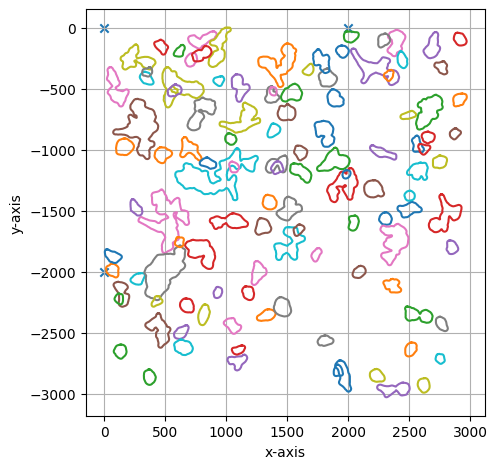

===== Collection Stats =====
Number of shapes: 115
Number of vertices: 16,789
Mean vertices: 146
Min vertices: 60
5% percentile vertices: 71
Median vertices: 103
95% percentile vertices: 332
Max vertices: 700
[0 0]
[      0 -200000]
[200000      0]
[10/04/2025 18:54:56] Saved output at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_sharded/selection/large_cells_small_cells.xml
[10/04/2025 18:54:57] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_o6leww5l'>


In [14]:
project.selection_f.segmentation_channel_to_select = "seg_all_cytosol" #update to the correct channel for this notebook with out loading a different config
project.select(cells_to_select, calibration_marker)